In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/lfw'
#'/content/drive/MyDrive/Colab Notebooks/lfw'

In [4]:
path = '/content/lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [25]:
if torch.backends.cuda.is_built():
    device = torch.device("cuda:0")
else:
    print ("Cuda device not found.")


torch.Size([250, 250, 3])


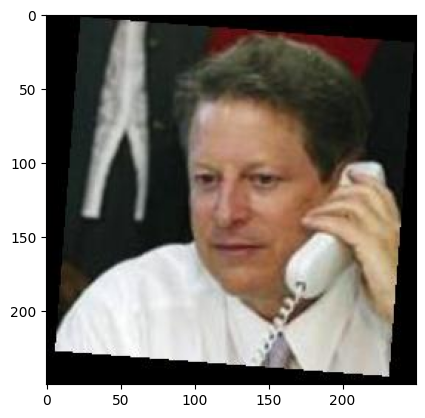

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [8]:
for x,y in dataloader:
    data = x
    print(x[0].shape)
    x = x[0].permute(1, 2, 0)
    print(x[1].type)
    print(x.shape)
    break

torch.Size([3, 250, 250])
<built-in method type of Tensor object at 0x7e801caaa430>
torch.Size([250, 250, 3])


Each datapoint is a multidimensional array that represents an image and the dimensions of each are 250, 250 and 3.
This represents an image with three dimesions: a Height of 250 pixels, a Width of 250 pixels, and 3 color channels.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [102]:
class AE(nn.Module):

    def __init__(self):
        super(AE,self).__init__()

    #def encoder(self,x):
    #def decoder(self,x):
    #def forward(self,x):
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=0),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=0),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
      h   = self.encoder(x)
      out = self.decoder(h)
      return out



## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [103]:
model = AE().to(device)

In [104]:
for data in dataloader:
  img,y = data
  img = img.to(device)
  #print(img.type)

  param_f = model.encoder(img)
  print("Encoder output shape: ", param_f.shape)
  mu_f, logvar_f = param_f.split(param_f.size(1)//2, 1)
  kl = - 0.5 * (1 + logvar_f - mu_f.pow(2) - logvar_f.exp())
  kl_loss = kl.sum() / img.size(0)
  std_f = torch.exp(0.5 * logvar_f)

  z = torch.randn_like(mu_f) * std_f + mu_f
  print("Z shape:", z.shape)
  output = model.decoder(z)
  print("Decoder output shape: ", output.shape)
  #encoder_out = model.encoder(img)
  #decoder_out = model.decoder(img)
  #print(encoder_out.shape)
  #print(decoder_out.shape)
  break


#for x,y in dataloader:
    #x = x[0].permute(1, 2, 0)
    #model.encoder(x)
#    break

#model.encoder(x)

Encoder output shape:  torch.Size([32, 8, 20, 20])
Z shape: torch.Size([32, 4, 20, 20])
Decoder output shape:  torch.Size([32, 1, 250, 250])


In [105]:

batch_size = 128
learning_rate = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [106]:
#Total number of parameters
print( sum(p.numel() for p in model.parameters() if p.requires_grad) )

5441


In [107]:
learning_rate = 1e-3
optim =torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

In [108]:
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [109]:
num_epochs = 5
for epoch in range(num_epochs):
    total_loss = 0
    for data in dataloader:
        img, y = data
        img = img.to(device)

        # ===================forward=====================

        param_f = model.encoder(img)
        mu_f, logvar_f = param_f.split(param_f.size(1)//2, 1)
        kl = - 0.5 * (1 + logvar_f - mu_f.pow(2) - logvar_f.exp())
        kl_loss = kl.sum() / img.size(0)
        std_f = torch.exp(0.5 * logvar_f)

        z = torch.randn_like(mu_f) * std_f + mu_f
        #print(z.shape)
        output = model.decoder(z)
        output = output[0]
        input = img
        #print(output[0].type)
        #print(len(output))
        #break
        fit = 0.5 * (output - input).pow(2)
        fit_loss = fit.sum() / input.size(0)
        loss = kl_loss + fit_loss

        loss = criterion(output, img)

        # ===================backward====================

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.data

    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, total_loss))
    #if epoch % 10 == 0:
        #pic = to_img(output.cpu().data)
        #save_image(pic, './generated/image_{}.png'.format(epoch))

epoch [1/5], loss:38.3464
epoch [2/5], loss:32.5978
epoch [3/5], loss:32.4133
epoch [4/5], loss:32.3090
epoch [5/5], loss:32.2597


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

In [ ]:
plt.imshow()

In [121]:
def plot_image_pair(x,y):
    plt.subplot(121)
    plt.imshow(x.detach().cpu().squeeze())
    plt.subplot(122)
    plt.imshow(y.detach().cpu().squeeze())

#x = img[3,:,:,:]

for x,y in dataloader:
    xt = model(x.to(device))
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)

    #xt = model(x);
    plt.imshow(xt)
    break

#x = img
#print(img[0].type)
#xt = model(x);
#plot_image_pair(x,xt)



RuntimeError: ignored

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?